In [34]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import IPython
import json
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score
from sklearn.preprocessing import RobustScaler, PowerTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
from keras import Model, layers, models, callbacks
from keras.callbacks.ModelCheckpoint import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Reshape, MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten, Input, LSTM
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import metrics

In [6]:
real_path = "KAGGLE/AUDIO/REAL"
fake_path = "KAGGLE/AUDIO/FAKE"
json_path = "KAGGLE/deep-voice-deepfake-voice-recognition-metadata.json"
csv_path = "KAGGLE/DATASET-balanced.csv"

with open(json_path, 'r') as f:
    metadata = json.load(f)

df = pd.read_csv(csv_path)
df['LABEL'] = df['LABEL'].apply(lambda x: 1 if x == 'REAL' else 0)
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,0
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,0
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,0
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,0
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,0


In [309]:
def extract_features(audio_path, sr, start_time, duration, label, id, time):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr, offset=start_time, duration=duration)
    
    # Extract features
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=y), axis=1)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr), axis=1)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y), axis=1)
    
    # Extract all 20 MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean = np.mean(mfcc, axis=1)  # Mean of all MFCC coefficients

    # Combine all features into one vector (8 base features + 20 MFCCs)
    features = np.concatenate([
        [np.mean(chroma_stft)], [np.mean(rms)], [np.mean(spectral_centroid)],
        [np.mean(spectral_bandwidth)], [np.mean(rolloff)], 
        [np.mean(zero_crossing_rate)], mfcc_mean, [label], [id], [time]
    ])

    return features


In [314]:
num_seconds = 10 
num_features = 29
num_total_segments = 11000
features = np.zeros((1, num_features))

file_index = 0
id = 0

for filename in os.listdir(real_path):
    if filename.endswith(".wav"):
        wav_file_path = os.path.join(real_path, filename)  # Ensure correct path
        duration = librosa.get_duration(filename=wav_file_path)
        max_segments = int(duration // num_seconds)  # Max number of 10-second segments we can extract
        # iterate through each segment
        for i in range(max_segments - 1):
            start_time = i * num_seconds
            for time in range(num_seconds):
                new_features  = extract_features(wav_file_path, 22050, start_time + time, 1, 1, id, time)
                features = np.concatenate((features, new_features.reshape(1, 29)), axis=0)
                file_index += 1
        id += 1


for filename in os.listdir(fake_path):
    if filename.endswith(".wav"):
        wav_file_path = os.path.join(fake_path, filename)  # Ensure correct path
        duration = librosa.get_duration(filename=wav_file_path)
        max_segments = int(duration // num_seconds)  # Max number of 10-second segments we can extract
        # iterate through each segment
        for i in range(max_segments - 1):
            start_time = i * num_seconds
            for time in range(num_seconds):
                new_features  = extract_features(wav_file_path, 22050, start_time + time, 1, 0, id, time)
                features = np.concatenate((features, new_features.reshape(1, 29)), axis=0)
                file_index += 1
        id += 1

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\3262978086.py:12: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=wav_file_path)
C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\3262978086.py:27: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=wav_file_path)


In [315]:
base_columns = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 
                'rolloff', 'zero_crossing_rate']
mfcc_columns = [f'mfcc{i+1}' for i in range(20)]
columns = base_columns + mfcc_columns + ['label', 'id', 'time']

df = pd.DataFrame(features, columns=columns)
df.to_csv('10_seconds_full.csv', index=False)

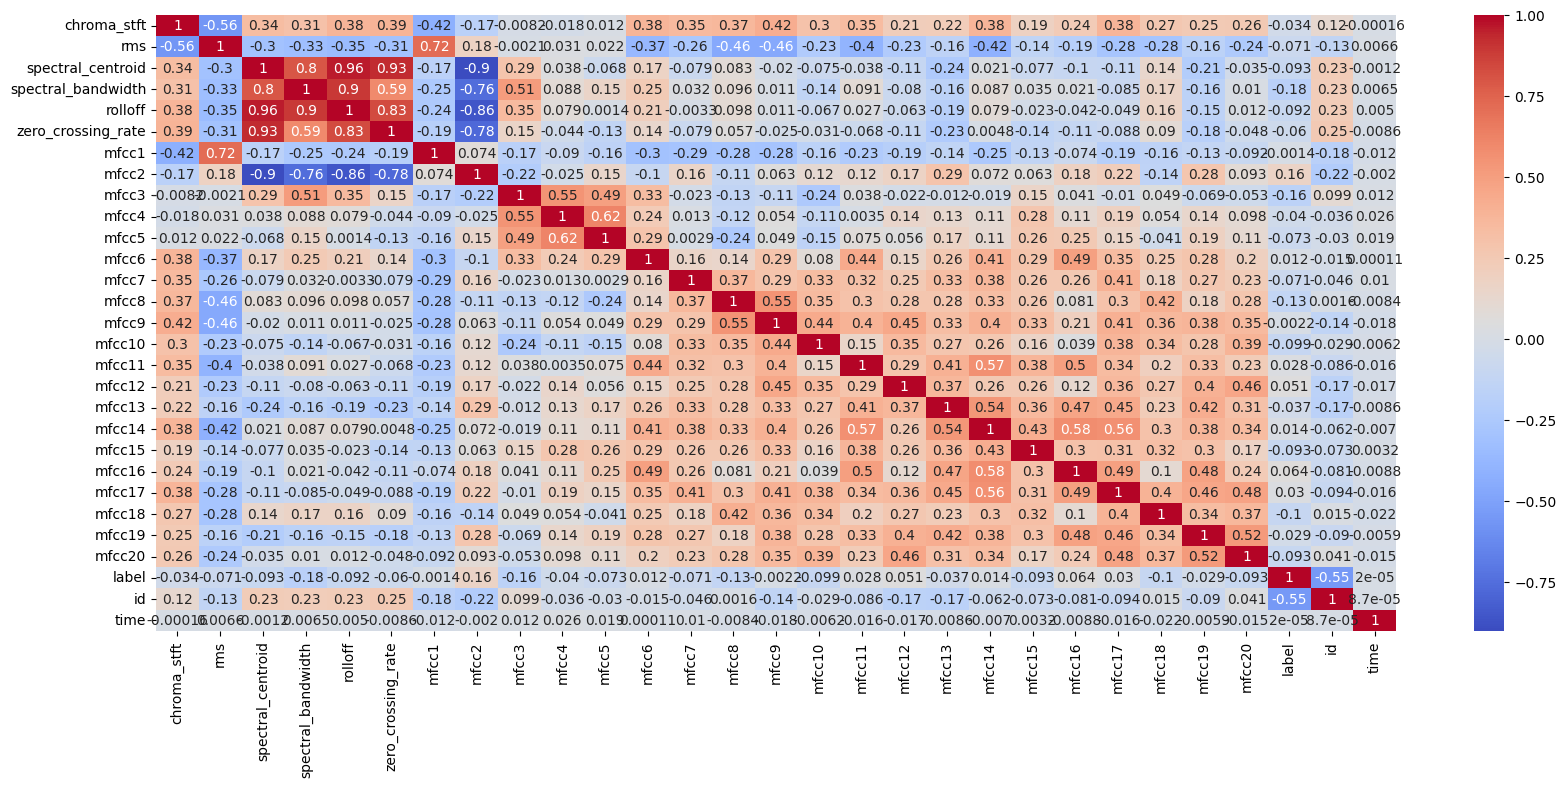

In [319]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

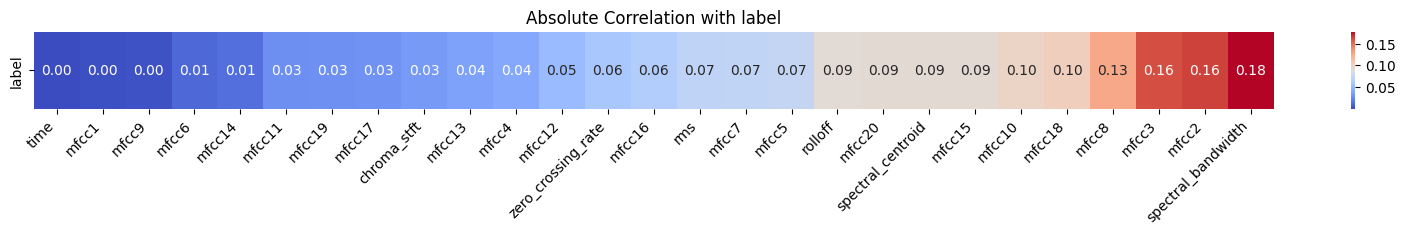

In [320]:
label_correlation = df.corr()['label'].drop('label').drop('id')
correlation = label_correlation.abs().to_frame().T
correlation = correlation.sort_values(by=correlation.index[0], axis=1, ascending=True)

plt.figure(figsize=(20, 1))
ax = sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Absolute Correlation with label")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


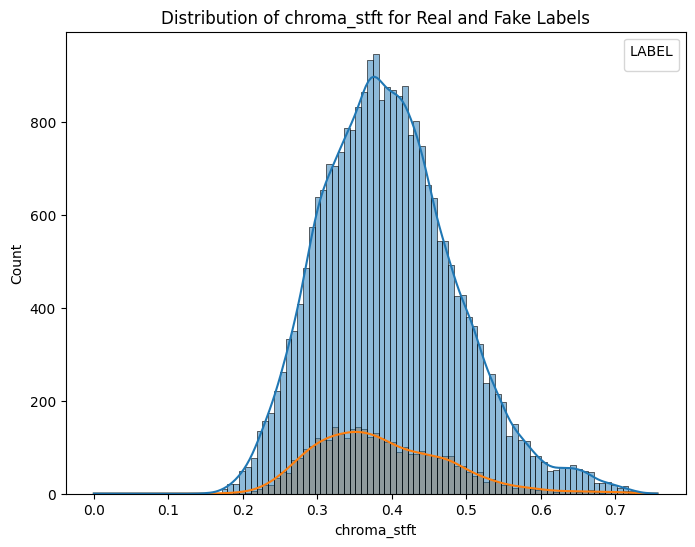

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


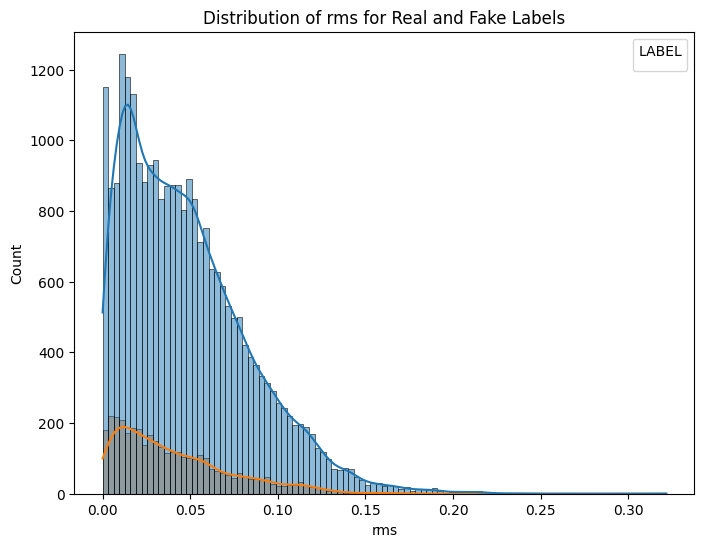

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


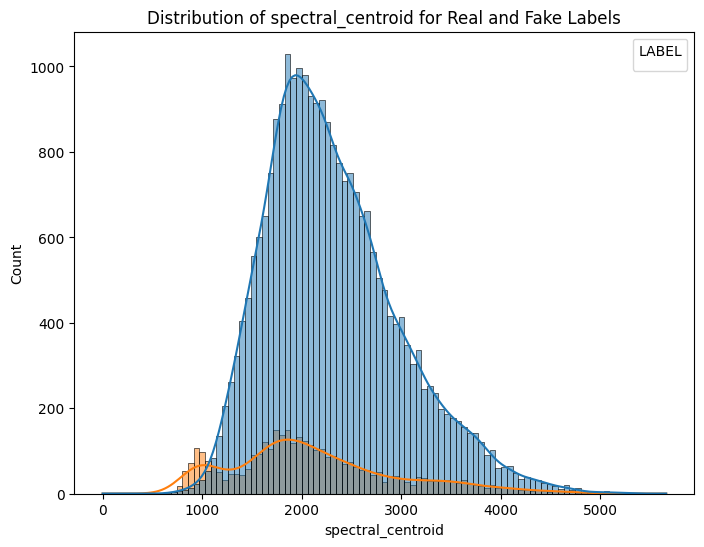

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


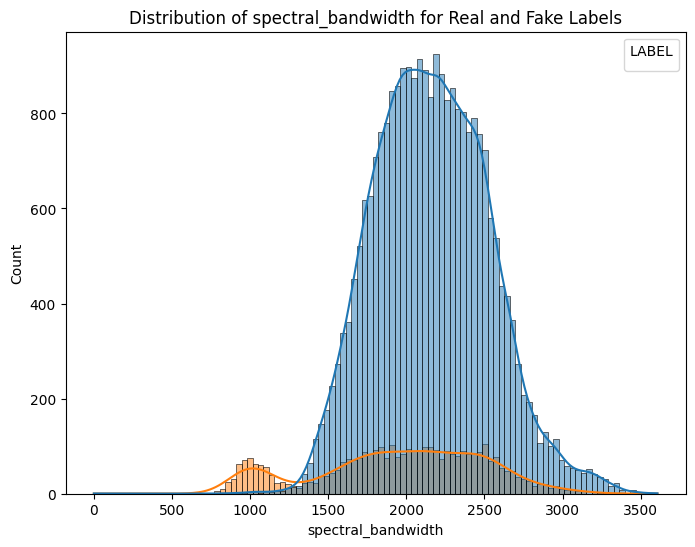

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


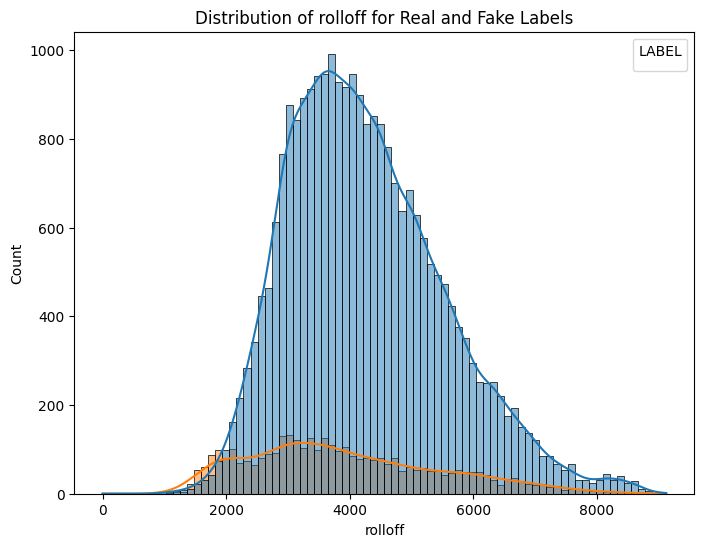

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


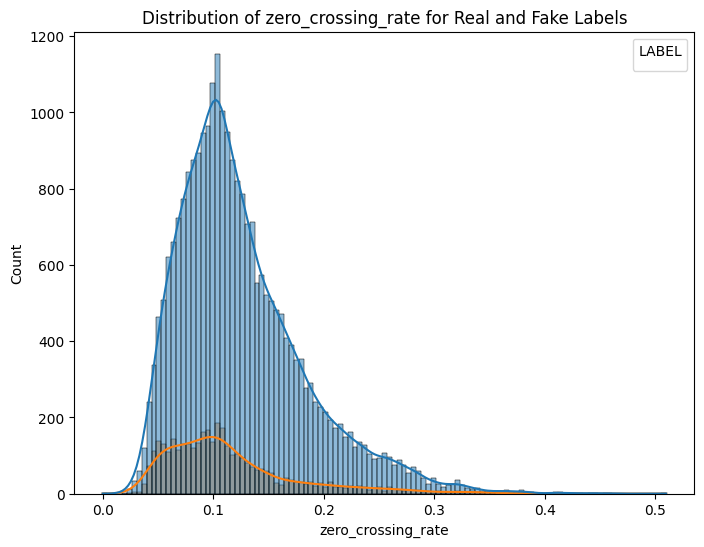

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


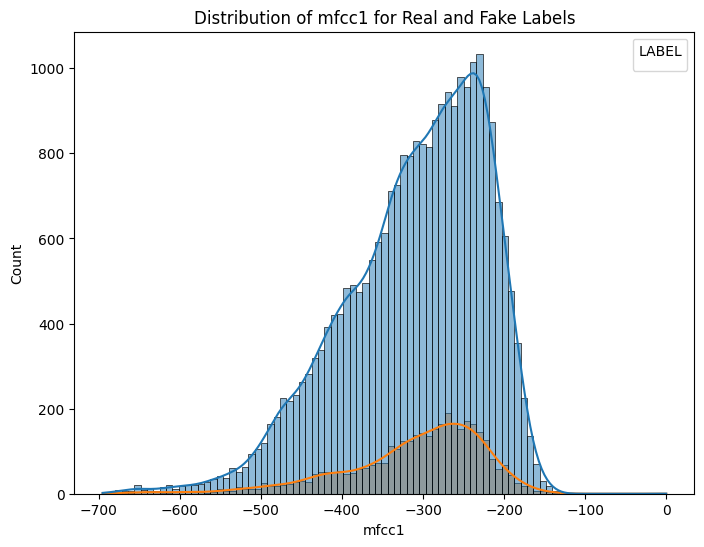

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


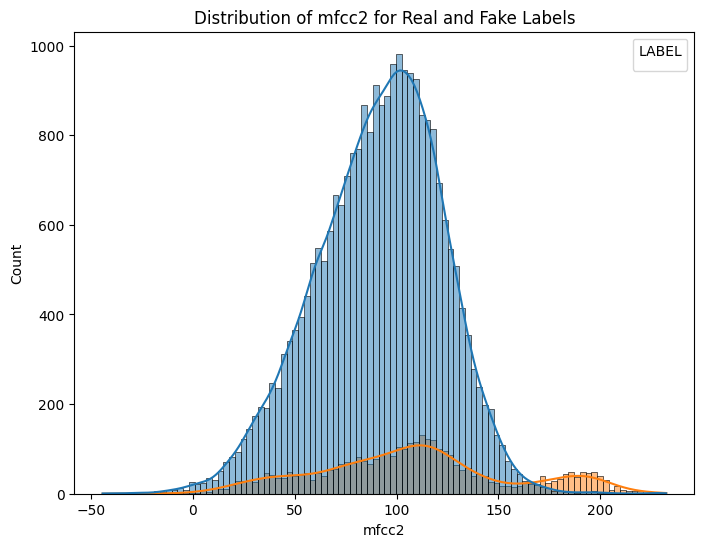

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


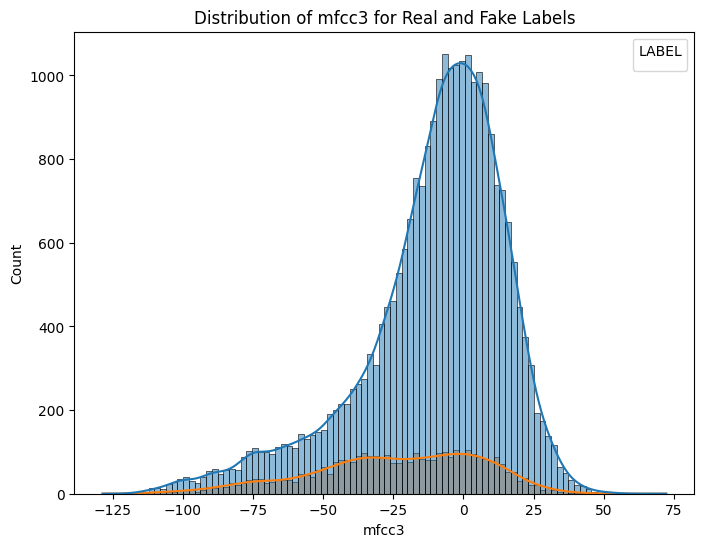

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


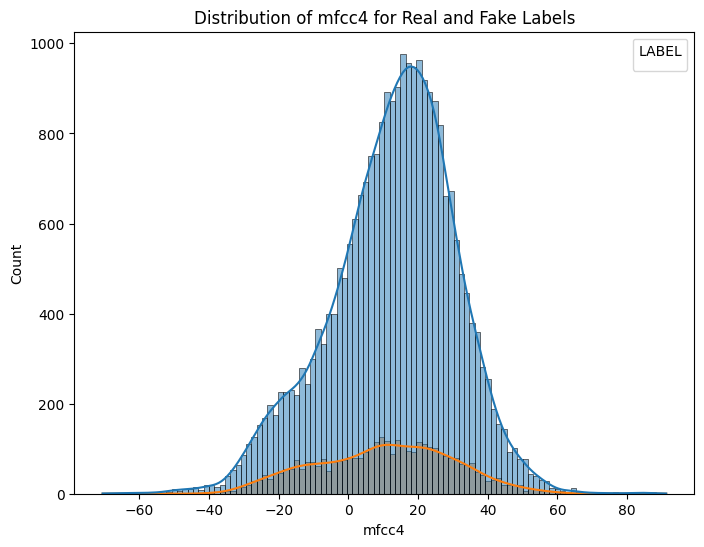

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


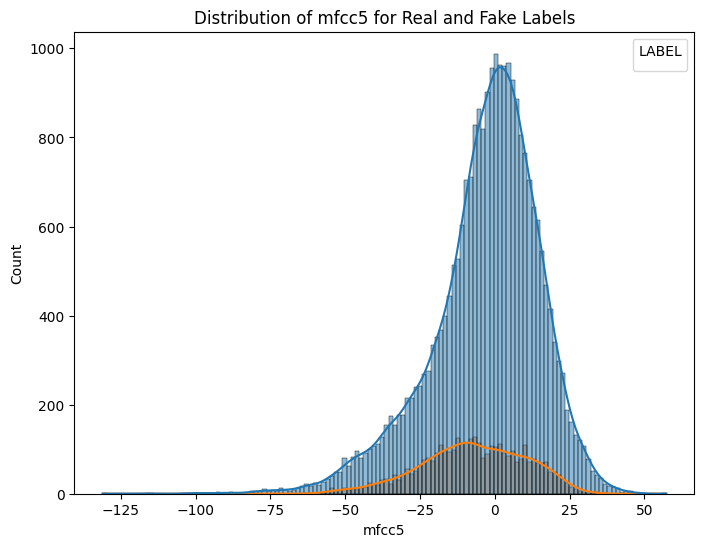

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


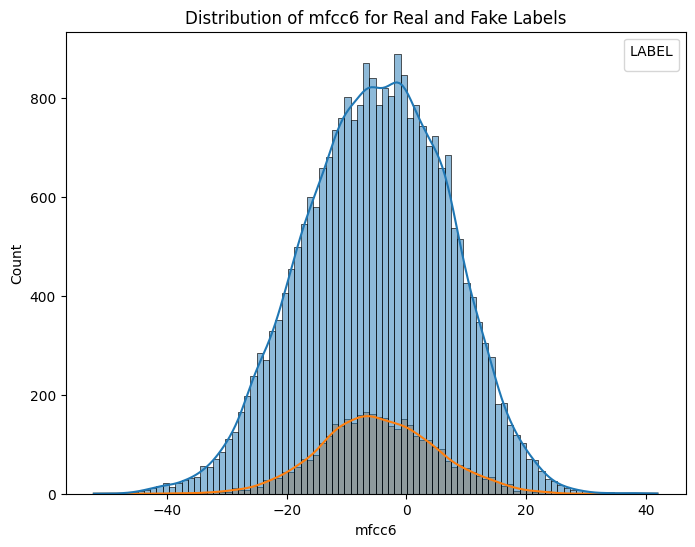

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


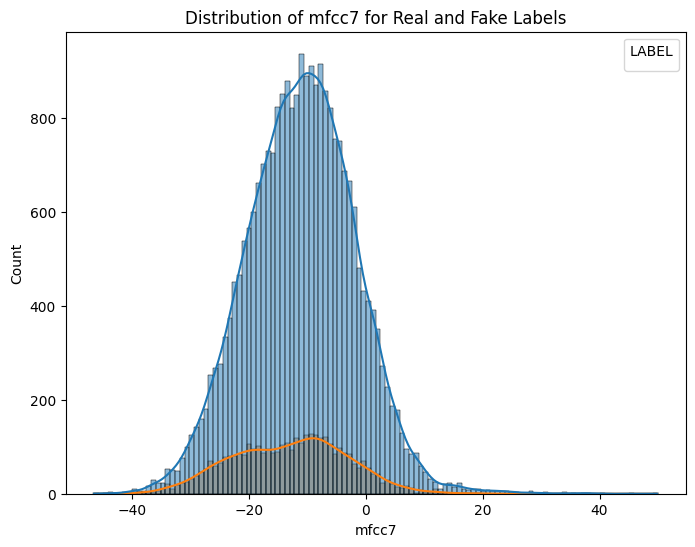

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


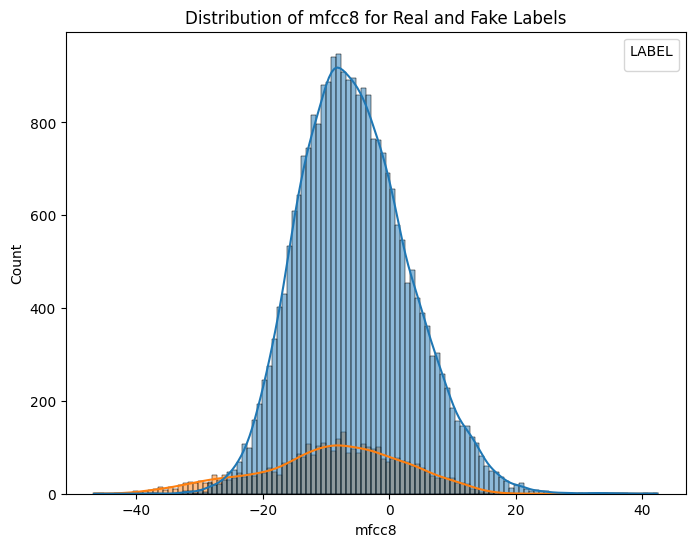

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


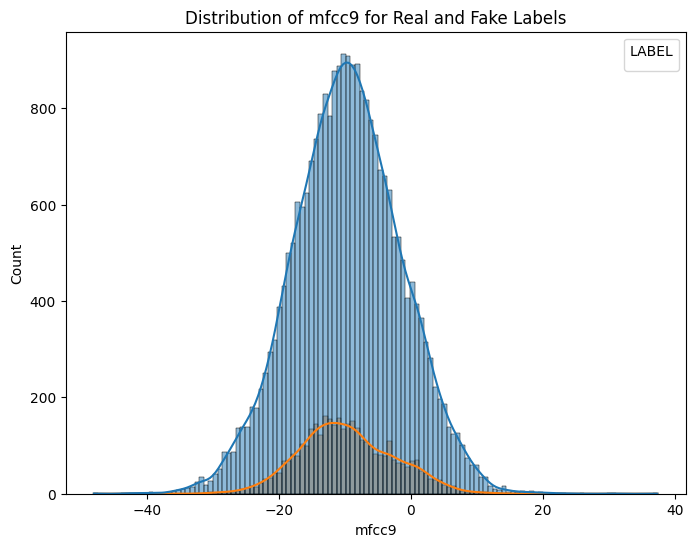

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


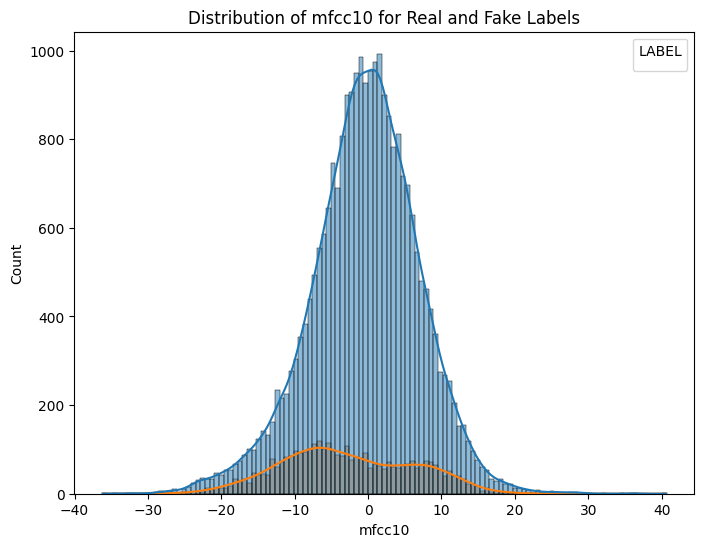

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


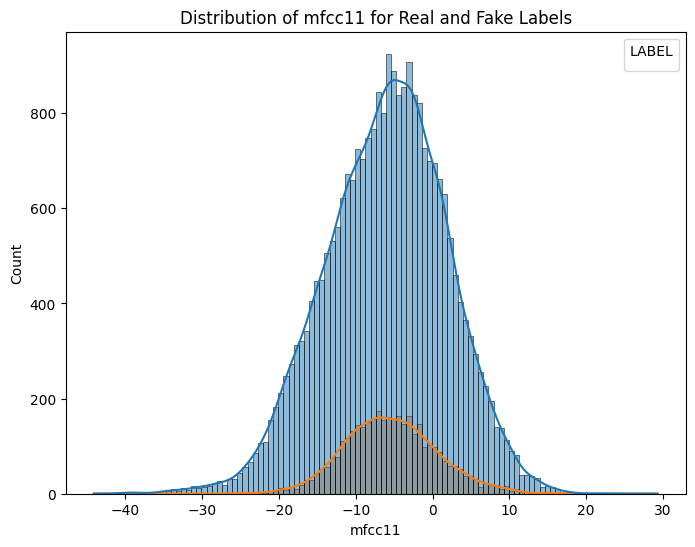

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


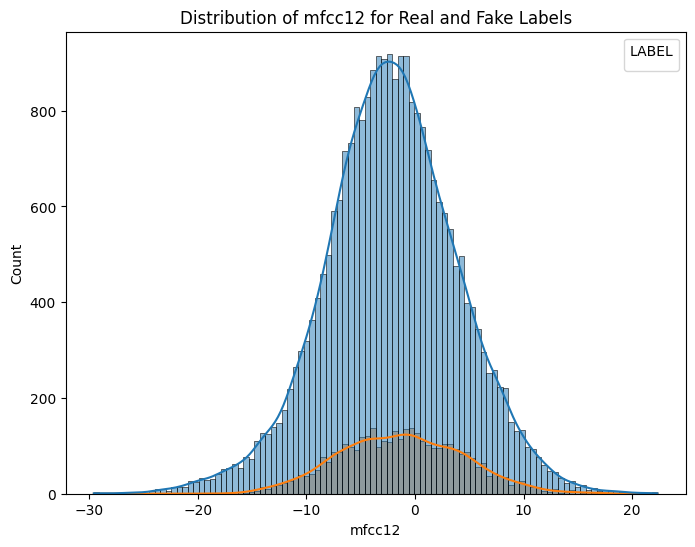

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


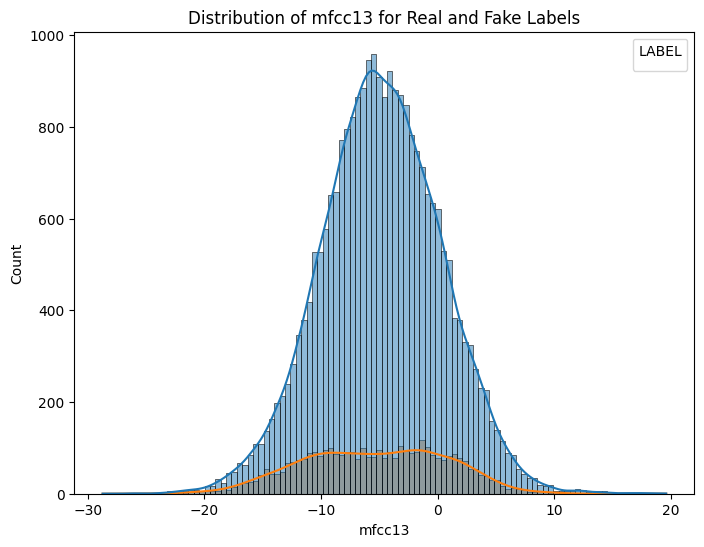

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


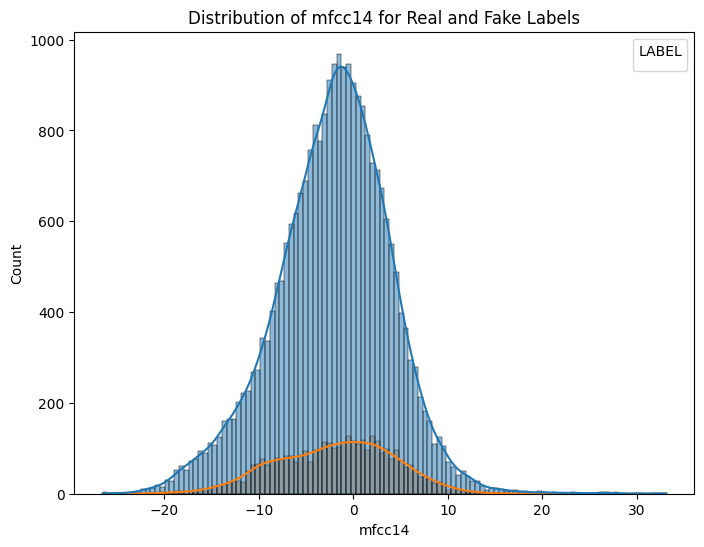

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


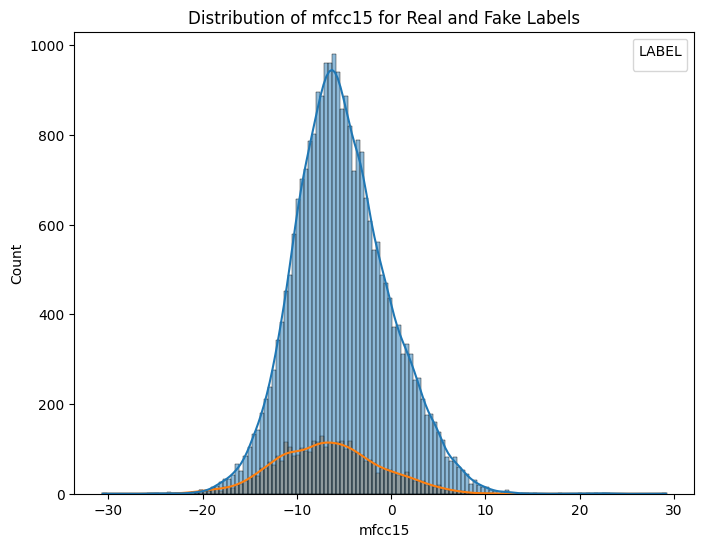

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


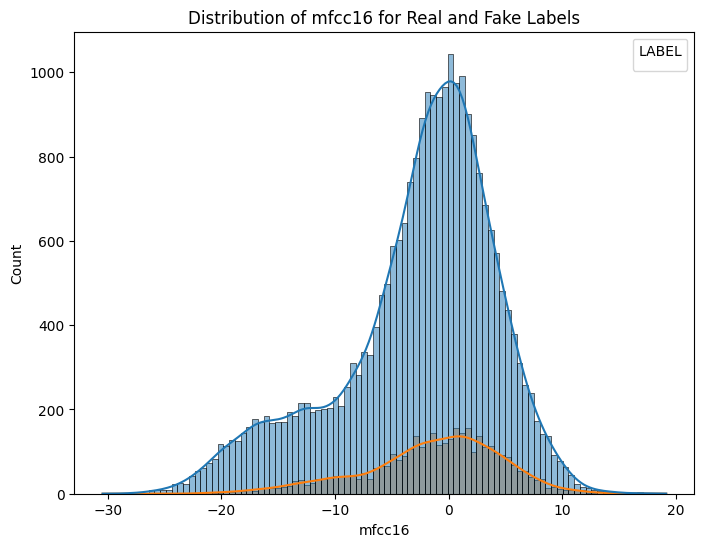

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


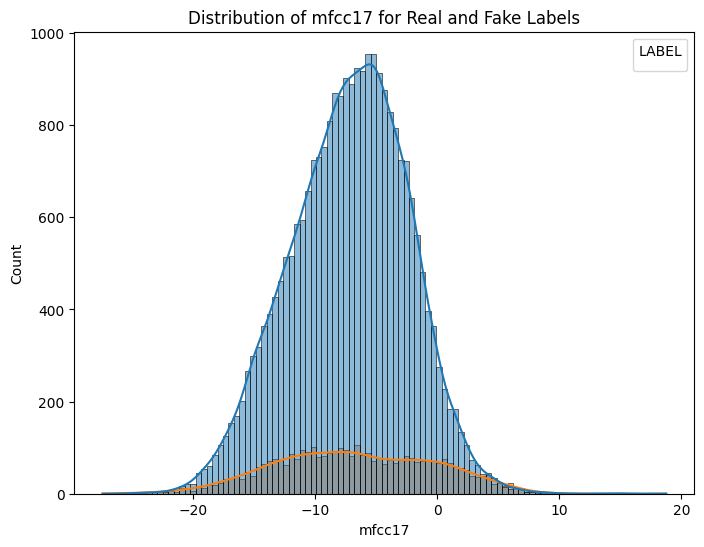

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


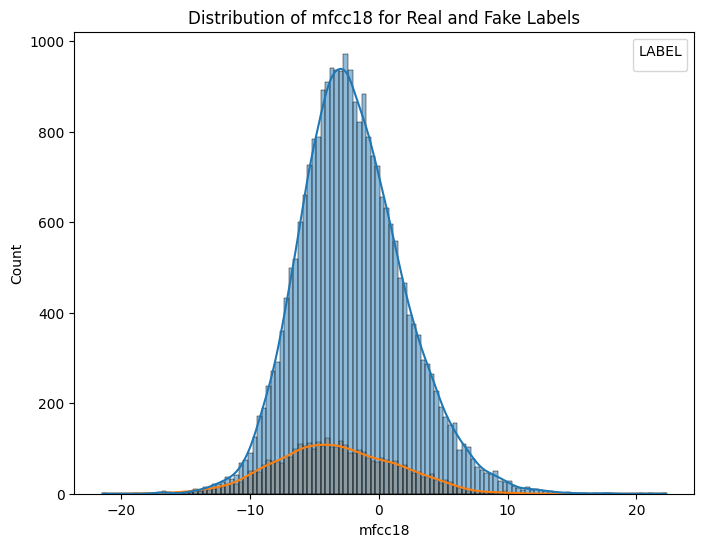

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


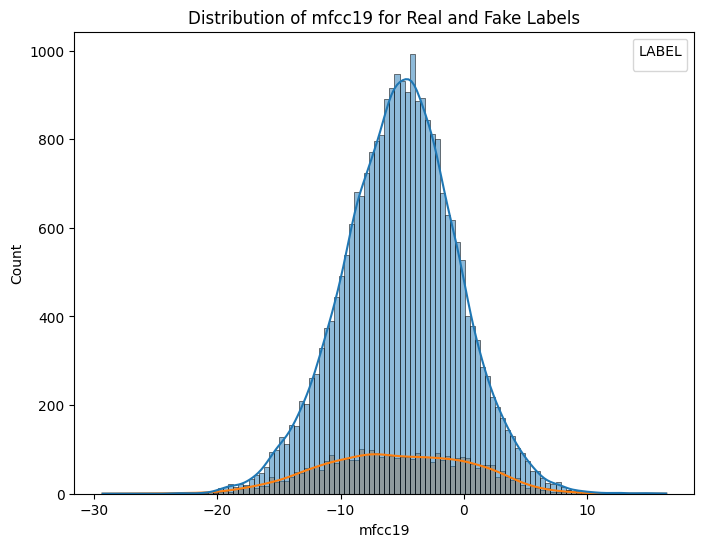

C:\Users\Kai\AppData\Local\Temp\ipykernel_73236\2165124683.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


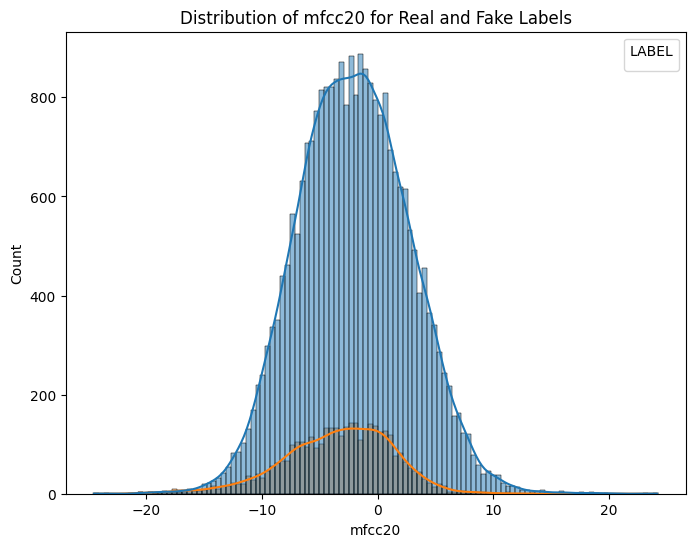

In [321]:
for var in columns:
    if var == 'label' or var == 'id' or var == 'time':
        continue
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.histplot(data=df, x=var, hue='label', kde=True, stat='count', common_norm=False)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(f'Distribution of {var} for Real and Fake Labels')
    plt.legend(title='LABEL')
    plt.show()

In [292]:
df = pd.read_csv(csv_path)
df['LABEL'] = df['LABEL'].apply(lambda x: 1 if x == 'REAL' else 0)

y = df['LABEL']
X = df.drop(columns=['LABEL'])

seed = 2002513
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=seed)

# "Logistic Regression"

In [293]:
model = LogisticRegression(max_iter=1000)
model.fit(xtr, ytr)

y_pred = model.predict(xte)
accuracy = accuracy_score(yte, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


c:\Users\Kai\Documents\Repo\DeepFake-Audio-Detection\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### "Logistic Regression with Scalar"

In [294]:
scaler = StandardScaler()
xtr_scaled = scaler.fit_transform(xtr)
xte_scaled = scaler.transform(xte)

model = LogisticRegression(max_iter=1000)
model.fit(xtr_scaled, ytr)
y_pred = model.predict(xte_scaled)
accuracy = accuracy_score(yte, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


In [322]:
df = pd.read_csv('10_seconds_full.csv')

y = df['label']
X = df.drop(columns=['label','id', 'time'])

seed = 2002513
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

scaler = StandardScaler()
xtr_scaled = scaler.fit_transform(xtr)
xte_scaled = scaler.transform(xte)

model = LogisticRegression(max_iter=1000)
model.fit(xtr_scaled, ytr)
y_pred = model.predict(xte_scaled)
accuracy = accuracy_score(yte, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


# "Custom LSTM Model"

In [51]:
def sigmoid(X):
    return 1 / (1+np.exp(-X))

def tanh(X):
    return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

def softmax(X):
    exp_X = np.exp(X)
    exp_X_sum = np.sum(exp_X, axis=1).reshape(-1, 1)
    exp_X = exp_X / exp_X_sum
    return exp_X

def tanh_derivative(X):
    return 1-(X**2)

In [74]:
def init_params(input_units, hidden_units, output_units):
    mean = 0
    std = 0.01    
    
    forget_gate_weights = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    input_gate_weights_percent  = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    input_gate_weights_memory  = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    output_gate_weights = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))


    forget_gate_bias = np.random.normal(mean,std,(1, hidden_units))
    input_gate_percent_bias = np.random.normal(mean,std,(1, hidden_units))
    input_gate_memory_bias = np.random.normal(mean,std,(1, hidden_units))
    output_gate_bias = np.random.normal(mean,std,(1, hidden_units))
    
    hidden_output_weights = np.random.normal(mean,std,(hidden_units,output_units))
    
    parameters = dict()
    parameters['fgw'] = forget_gate_weights
    parameters['igpw'] = input_gate_weights_percent
    parameters['igmw'] = input_gate_weights_memory
    parameters['ogw'] = output_gate_weights

    parameters['fgb'] = forget_gate_bias
    parameters['igpb'] = input_gate_percent_bias
    parameters['igmb'] = input_gate_memory_bias
    parameters['ogb'] = output_gate_bias
    
    return parameters


In [75]:
def lstm_cell(parameters, short_term_matrix, long_term_matrix, input_matrix):
    fgw = parameters['fgw']
    igpw = parameters['igpw']
    igmw = parameters['igmw']
    ogw = parameters['ogw']
    
    
    fgb = parameters['fgb']
    igpb = parameters['igpb']
    igmb = parameters['igmb']
    ogb = parameters['ogb']

    # concatenate input and short term memory matrix
    concat_dataset = np.concatenate((short_term_matrix, input_matrix), axis=1)

    # forget gate
    fa = np.matmul(concat_dataset, fgw)
    fa = np.add(fa, fgb)
    forget_gate_output = sigmoid(fa)

    # input gate
    input_potential = np.matmul(concat_dataset, igpw)
    input_potential = np.add(input_potential, igpb)
    input_potential = sigmoid(input_potential)

    input_memory = np.matmul(concat_dataset, igmw)
    input_memory = np.add(input_memory, igmb)
    input_memory = tanh(input_memory)

    input_gate_output = input_potential * input_memory

    # update long term memory
    long_term_memory = np.multiply(long_term_matrix, forget_gate_output)
    long_term_memory = np.add(long_term_memory, input_gate_output)

    # output gate
    output_percent = np.matmul(concat_dataset, ogw)
    output_percent = np.add(output_percent, ogb)
    output_percent = sigmoid(output_percent)

    output_potential = tanh(long_term_memory)

    # update short term memory
    short_term_memory = np.multiply(output_percent, output_potential)

    # return long and short term memory
    return long_term_memory, short_term_memory

In [88]:
# Assuming the input size and hidden units for the LSTM
input_units = 26  # Number of features in the input
hidden_units = 128  # Number of LSTM hidden units
output_units = 1  # Output units (optional for full model)


# Initialize the parameters
parameters = init_params(input_units, hidden_units, output_units)

input_matrix = xtr
# Create a sample short-term memory (previous hidden state, [1, 128])
short_term_matrix = np.random.randn(20, hidden_units)  # Short-term memory from the previous time step

# Create a sample long-term memory (previous cell state, [1, 128])
long_term_matrix = np.random.randn(20, hidden_units)  # Long-term memory from the previous time step

# Run the LSTM cell
new_long_term_memory, new_short_term_memory = lstm_cell(parameters, short_term_matrix, long_term_matrix, input_matrix)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 20 and the array at index 1 has size 9422